In [5]:
import pandas as pd
import graphviz
import numpy as np
from algorithm_ranking import MeasurementsVisualizer, MeasurementsSimulator

In [2]:
class Node:
    def __init__(self,name):
        self.name = name
        self.in_nodes = set()
        self.out_nodes = set()
        
    def add_in_node(self, node):
        self.in_nodes.add(node)
        
    def remove_in_node(self, node):
        self.in_nodes.remove(node)
        
    def add_out_node(self, node):
        self.out_nodes.add(node)
        
    def remove_out_node(self, node):
        self.out_nodes.remove(node)
        
    def depth(self):
        depth = 0
        if self.in_nodes:
            depth = max([ n.depth() + 1 for n in self.in_nodes])
        return depth
                          
    def __str__(self):
        return "{}".format(self.name)

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges_in = {}
        self.edges_out = {}
        self.node_depth = {}
    
    def add_node(self,node):
        self.nodes[node]  = Node(node)
        self.edges_in[node] = []
        self.edges_out[node] = []
        self.node_depth[node] = 0
        
        
    def add_edge(self, node_x, node_y):
        if node_y not in self.edges_out[node_x]:
            print("Adding edge from {} to {}".format(node_x,node_y))
            self.edges_out[node_x].append(node_y)
            self.nodes[node_x].add_out_node(self.nodes[node_y])

            self.edges_in[node_y].append(node_x)
            self.nodes[node_y].add_in_node(self.nodes[node_x])
    
        
    def remove_edge(self, node_x, node_y):
        print("Removing edge from {} to {}".format(node_x,node_y))
        try:
            self.edges_out[node_x].remove(node_y)
            self.nodes[node_x].remove_out_node(self.nodes[node_y])    
            
            self.edges_in[node_y].remove(node_x)
            self.nodes[node_y].remove_in_node(self.nodes[node_x]) 
            
        except ValueError:
            print("Edge does not exist")
     
    def calculate_node_depth(self):
        for alg,node in self.nodes.items():
            self.node_depth[alg] = node.depth()
            
    def get_nodes_at_depth(self,depth):
        #self.calculate_node_depth()
        df = pd.DataFrame(self.node_depth.items())
        return list(df.loc[df[1] == depth][0])
    
    def visualize(self,highlight_nodes=[]):
        g = graphviz.Digraph()
        for node in self.nodes.keys():
            color='#f0efed'
            if node in highlight_nodes:
                color = '#f2ecc7'
            g.node(node,style='filled',color=color)
        for node1,v in self.edges_out.items():
            for node2 in v:
                if node2 in highlight_nodes:
                    g.edge(node1, node2, style='filled', color='blue')
                else:
                    g.edge(node1, node2)
        return g
        

In [3]:
class CompareAlgs:
    def __init__(self, measurements, h0):
        self.measurements = measurements
        self.h0 = h0
        self.comparision_matrix = {}
        self.init_comparision_matrix()
        
    def init_comparision_matrix(self):
        self.comparision_matrix = {}
        for alg in self.h0:
            self.comparision_matrix[alg] = {}
            for alg2 in self.h0:
                self.comparision_matrix[alg][alg2] = -1
                
    def get_measurements(self, alg):
        return self.measurements[alg]

    def remove_outliers(self, x):
        x = np.array(x)
        q1, q2 = np.percentile(x,  [25,75])
        iqr = q2-q1
        fence_low = q1 - 1.5*iqr
        fence_high = q2 + 1.5*iqr
        return x[(x>fence_low) & (x <fence_high)]

    def get_quartiles(self, measurements, q_max=75, q_min=25):
        return np.percentile(self.remove_outliers(measurements), [q_max, q_min])
        
        
    def compare(self, alg1, alg2, q_max=75, q_min=25):
        #print(alg1, alg2)
        if self.comparision_matrix[alg1][alg2] != -1:
            return self.comparision_matrix[alg1][alg2]

        t_alg1 = self.get_measurements(alg1)
        t_alg2 = self.get_measurements(alg2)

        q1_max, q1_min = self.get_quartiles(t_alg1, q_max, q_min)
        q2_max, q2_min = self.get_quartiles(t_alg2, q_max, q_min)
        # print(alg1, q1_max, q1_min)
        # print(alg2, q2_max, q2_min)

        ret = 1  # alg1 ~ alg2
        if q1_max < q2_min:
            ret = 0  # alg1 is faster than alg2
        elif q2_max < q1_min:
            ret = 2  # alg2 is faster than alg1

        self.comparision_matrix[alg1][alg2] = ret
        if ret == 0:
            self.comparision_matrix[alg2][alg1] = 2
        elif ret == 2:
            self.comparision_matrix[alg2][alg1] = 0
        else:
            self.comparision_matrix[alg2][alg1] = ret

        #print(ret)
        #print("\n")
        return ret

In [92]:
class RankBrute:
    def __init__(self, h0, compareAlgs):
        self.h0 = h0
        
        self.graph = None
        self.dfr = {}
        self.init_graph(h0)   
        self.compareAlgs = compareAlgs

        
    def init_graph(self, h0):
        self.graph = Graph()

        for alg in h0:
            self.graph.add_node(alg)
            self.dfr[alg] = []

        #for i in range(len(h0)):
        #    if i!=len(h0)-1:
        #        self.graph.add_edge(h0[i], h0[i+1])

        #self.graph.calculate_node_depth()
        
        #self.start = self.graph.get_nodes_at_depth(0)[0]
        #self.preset = self.graph.edges_in.copy()
        #self.visited_sets = []
        #self.deleted_sets = []
        
     
    def deduce_transitivity(self, alg_i, alg_j, ret):
        if ret == 0:
            self.graph.add_edge(alg_i, alg_j)
            for alg in self.dfr[alg_i]:
                compareAlgs.comparision_matrix[alg][alg_j] = 0
                self.graph.add_edge(alg, alg_j)
                compareAlgs.comparision_matrix[alg_j][alg] = 2
                self.dfr[alg].append(alg_j)
            self.dfr[alg_j].append(alg_i)
            
        if ret == 2:
            for alg in self.dfr[alg_j]:
                compareAlgs.comparision_matrix[alg][alg_i] = 2
                compareAlgs.comparision_matrix[alg_i][alg] = 0
                self.graph.add_edge(alg_i, alg)
                self.dfr[alg_i].append(alg)
            self.dfr[alg_i].append(alg_j)
            
        
    def rank(self):
        for i in range(len(h0)):
            for j in range(len(h0)):
                alg_i =  h0[i]
                alg_j =  h0[j]
                if compareAlgs.comparision_matrix[alg_i][alg_j] != -1:
                    continue
                ret = compareAlgs.compare(alg_i, alg_j)
                self.deduce_transitivity(alg_i, alg_j, ret)
                    

In [93]:
cfg = {}
cfg['alg0']  = [0.1,0.02] #[mean, std]
cfg['alg1']  = [0.15,0.01]
cfg['alg2']  = [0.16,0.02]
cfg['alg3']  = [0.17,0.04]
cfg['alg4']  = [0.20,0.02]
h0 = list(cfg.keys())

In [94]:
h0

['alg0', 'alg1', 'alg2', 'alg3', 'alg4']

In [95]:
ms = MeasurementsSimulator(cfg, 'normal', seed=152)     
ms.measure(30,1)
data = ms.get_alg_measurements()
compareAlgs = CompareAlgs(data, h0)

In [96]:
rank = RankBrute(h0,compareAlgs)

In [97]:
rank.rank()

Adding edge from alg0 to alg1
Adding edge from alg0 to alg2
Adding edge from alg0 to alg3
Adding edge from alg0 to alg4
Adding edge from alg1 to alg4
Adding edge from alg2 to alg4


In [98]:
pd.DataFrame(compareAlgs.comparision_matrix)

,alg0,alg1,alg2,alg3,alg4
alg0,1,2,2,2,2
alg1,0,1,1,1,2
alg2,0,1,1,1,2
alg3,0,1,1,1,1
alg4,0,0,0,1,1


In [99]:
rank.h0

['alg0', 'alg1', 'alg2', 'alg3', 'alg4']

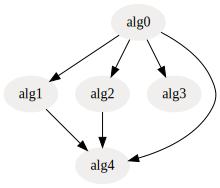

In [101]:
rank.graph.visualize()

In [75]:
compareAlgs.compare('alg1','alg0')

2

In [76]:
rank.dfr

{'alg0': ['alg4', 'alg4'],
 'alg1': ['alg0'],
 'alg2': ['alg0'],
 'alg3': ['alg0'],
 'alg4': ['alg0', 'alg1', 'alg2']}

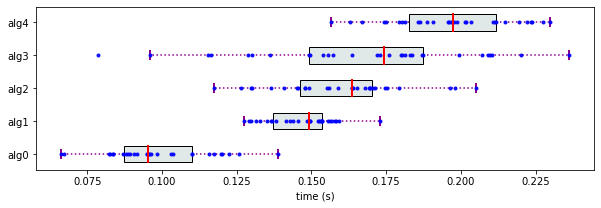

In [77]:
mv = MeasurementsVisualizer(ms.get_alg_measurements(), h0)
fig = mv.show_measurements_boxplots(scale=0.6)